# 리눅스 특성
- 소스코드를 다운받아서 컴파일하기

# yolo
> dark net
- C로 구현
- dark net 위에 yolo를 얹어서 detection을 만듦.
- darkflow: tensorflow 기반
    
    
# 할일
> 1. clone
- git clone https://github.com/pjreddie/darknet
> 2. gpu 사용하기
- vi Makefile
- gpu = 1
- CUDNN = 1
- OPENCV = 1

> 편집기 모드
- vi : vi 연습가능
- esc: 명령어 모드
- a  / i: editor 모드
- 붙여넣기: 윈도우에서 복사한뒤(ctrl + c) + ctrl + v
- 저장: esc(명령어 모드 ) -> :wq (:- command mode, w- write, q - quit)
- 강제 종료: !q

> 3. 컴파일하기
- make
- make : 파일 간의 종속관계를 파악하여 Makefile( 기술파일 )에 적힌 대로 컴파일러에 명령하여 SHELL 명령이 순차적으로 실행될 수 있게 합니다.

> 4. activate
- conda activate tensorflow2_p36

> 5. weight 가져오기
-  wget https://pjreddie.com/media/files/yolov3.weights

> 6. 실행하기
-./darknet detect cfg/yolov3.cfg yolov3.weights data/dog.jpg

> 7. 결과 저장
- predictions.jpg

# yolo test

In [29]:
import cv2 
import argparse
import numpy as np
import os.path
from matplotlib import pyplot as plt
%matplotlib inline

def imshow(tit, image) :
    plt.title(tit)    
    if len(image.shape) == 3 :
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else :
        plt.imshow(image, cmap="gray")
    plt.show()

In [30]:
# Initialize the parameters
confThreshold = 0.5  #Confidence threshold
nmsThreshold = 0.4   #Non-maximum suppression threshold
inpWidth = 416       #Width of network's input image
inpHeight = 416      #Height of network's input image

# Load names of classes
classesFile = "coco.names"
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')
print(classes)
# Give the configuration and weight files for the model and load the network using them.
modelConfiguration = "yolov3.cfg"
modelWeights = "yolov3.weights"

net = cv.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [31]:
# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# Draw the predicted bounding box
def drawPred(classId, conf, left, top, right, bottom):
    # Draw a bounding box.
    cv2.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
    
    label = '%.2f' % conf
        
    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    #Display the label at the top of the bounding box
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv2.FILLED)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)

# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(classIds[i], confidences[i], left, top, left + width, top + height)

In [32]:
cap = cv2.VideoCapture('images/dog.jpg')

hasFrame, frame = cap.read()

#inpWidth =  frame.shape[1]
#inpHeight = frame.shape[0]
# 여기서 inpWidth는 영상의 크기가 아님.
blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

net.setInput(blob)

outs = net.forward(getOutputsNames(net))

postprocess(frame, outs)

t, _ = net.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
cv2.putText(frame, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

array([[[245, 250, 253],
        [242, 247, 250],
        [250, 255, 255],
        ...,
        [249, 254, 253],
        [249, 254, 253],
        [249, 254, 253]],

       [[249, 252, 255],
        [245, 250, 251],
        [248, 253, 254],
        ...,
        [249, 254, 253],
        [249, 254, 253],
        [249, 254, 253]],

       [[251, 255, 255],
        [248, 252, 253],
        [244, 252, 252],
        ...,
        [247, 253, 252],
        [248, 254, 253],
        [248, 254, 253]],

       ...,

       [[244, 253, 255],
        [244, 253, 255],
        [246, 253, 255],
        ...,
        [240, 254, 253],
        [244, 254, 254],
        [247, 255, 255]],

       [[245, 254, 255],
        [245, 254, 255],
        [246, 253, 255],
        ...,
        [244, 254, 254],
        [247, 255, 255],
        [250, 254, 255]],

       [[246, 255, 255],
        [245, 254, 255],
        [246, 253, 255],
        ...,
        [247, 255, 255],
        [250, 254, 255],
        [251, 253, 254]]

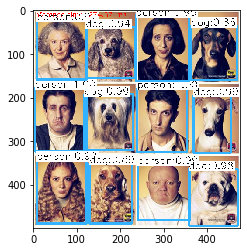

In [33]:
cv2.imwrite("out.jpg", frame) 
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [34]:
cap = cv2.VideoCapture('images/many.jpg')

hasFrame, frame = cap.read()

#inpWidth =  frame.shape[1]
#inpHeight = frame.shape[0]
# 여기서 inpWidth는 영상의 크기가 아님.
blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

net.setInput(blob)

outs = net.forward(getOutputsNames(net))

postprocess(frame, outs)

t, _ = net.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
cv2.putText(frame, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

array([[[225, 232, 231],
        [225, 232, 231],
        [225, 232, 231],
        ...,
        [226, 228, 226],
        [226, 228, 226],
        [226, 228, 226]],

       [[225, 232, 231],
        [225, 232, 231],
        [225, 232, 231],
        ...,
        [226, 228, 226],
        [226, 228, 226],
        [226, 228, 226]],

       [[225, 232, 231],
        [225, 232, 231],
        [225, 232, 231],
        ...,
        [226, 228, 226],
        [226, 228, 226],
        [226, 228, 226]],

       ...,

       [[203, 208, 211],
        [203, 208, 211],
        [203, 208, 211],
        ...,
        [216, 219, 221],
        [216, 219, 221],
        [216, 219, 221]],

       [[203, 208, 211],
        [203, 208, 211],
        [203, 208, 211],
        ...,
        [216, 219, 221],
        [216, 219, 221],
        [216, 219, 221]],

       [[203, 208, 211],
        [203, 208, 211],
        [203, 208, 211],
        ...,
        [216, 219, 221],
        [216, 219, 221],
        [216, 219, 221]]

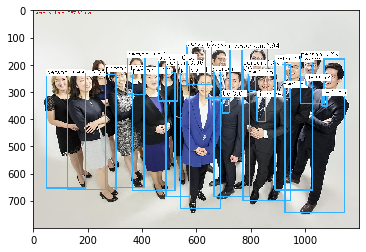

In [35]:
cv2.imwrite("out.jpg", frame) 
img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(img)